In [2]:
import numpy as np
import torch
import math
!pip install gpytorch
import gpytorch
from gpytorch.kernels.rbf_kernel import postprocess_rbf

     |████████████████████████████████| 286kB 12.7MB/s 
  Created wheel for gpytorch: filename=gpytorch-1.4.0-py2.py3-none-any.whl size=477826 sha256=5d7b4daec7f1a021174589e5480db84649cdb92b57d65b1580796b75393497d0
  Stored in directory: /root/.cache/pip/wheels/fd/f5/39/404e1875f841e8a999e94a7efa17f6ef900298be5452b63b0c
Successfully built gpytorch


In [3]:
# train_x = torch.linspace(0, 1, 100)
# train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)
train_x = torch.linspace(-2, 2, 20)
train_y = torch.sin(train_x)+train_x


def get_proj_matrix(D,d,hypersphere=0):
  A = np.random.normal(0,1,(D,d))
  if hypersphere==1:
    for row in range(D):
      N = np.linalg.norm(A[row,:])
      A[row,:] = A[row,:]/N
  return A


class AleboKernel(gpytorch.kernels.Kernel):
  def __init__(self,B,batch_shape):
    super().__init__(has_length=False,ard_num_dims=None,eps=0.0,batch_shape=batch_shape)
    self.d = B.shape[0]
    self.D = B.shape[1]
    self.B = B
    self.Binv = torch.pinverse(B)
    # self.dtype = B.dtype
    self.batch_shape = batch_shape

    A = torch.qr(torch.randn(self.D,self.D))[0]
    ABinv = A[:self.d,:] @ self.Binv
    T = ABinv.t() @ ABinv
    U = torch.cholesky(T,upper = True)
    self.idx = U.nonzero().t().tolist()
    self.Uvec = U[self.idx].repeat(*batch_shape,1)
    self.register_parameter(name = "UVec",parameter=torch.nn.Parameter(self.Uvec))
    
  def forward(self,x1,x2,**params):
    U_t = torch.zeros(self.Uvec.shape[:-1]+torch.Size([self.d,self.d]))
    U_t[...,self.idx[1],self.idx[0]] = self.Uvec

    z1 = x1 @ U_t
    z2 = x2 @ U_t

    return self.covar_dist(z1,z2,square_dist=True,dist_postprocess_func=postprocess_rbf,**params)

class AleboGP(gpytorch.models.ExactGP):
  def __init__(self, train_x, train_y, likelihood,B):
    super().__init__(train_x, train_y, likelihood)
    self.covar_module = gpytorch.kernels.ScaleKernel(base_kernel=AleboKernel(B=B, batch_shape=torch.Size([1])),batch_shape=torch.Size([1]))
    self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([1]))
  def forward(self,x):
    mean_x = self.mean_module(x)
    covar_x = self.covar_module(x)
    return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

B = torch.tensor(get_proj_matrix(1,3,1),dtype=torch.float32)
likelihood = gpytorch.likelihoods.GaussianLikelihood(batch_shape=torch.Size([1]))
model = AleboGP(train_x, train_y, likelihood,B)



In [4]:
def train(model,likelihood,train_x,train_y,training_iter=50):
# training_iter = 50
  model.train()
  likelihood.train()

  optimizer = torch.optim.Adam(model.parameters(), lr=0.1) 

  mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)


  for i in range(training_iter):
      optimizer.zero_grad()
      output = model(train_x)

      loss = -mll(output, train_y)
      loss.backward()
      optimizer.step()
  
  model.eval()
  likelihood.eval()
  
  return model,likelihood


In [8]:
def get_r2_square(model,likelihood,train_x,train_y):
  observed_pred = likelihood(model(train_x))
  lower,upper = observed_pred.confidence_region()
  r2_square = 0
  # sum_diff = 0
  for i in range(train_x.shape[0]):
    r2_square += (observed_pred.mean[0][i].detach().numpy()-train_x[0][i].numpy())**2
  sum_diff += np.sum(upper[0,:].detach().numpy())-np.sum(lower[0,:].detach().numpy())

  return r2_square,sum_diff
    
def get_best_fit_gp(n_trials=10):
  best_state = {}
  r2_square = 1e9
  for i in range(n_trials):
    likelihood = gpytorch.likelihoods.GaussianLikelihood(batch_shape=torch.Size([1]))
    model = AleboGP(train_x, train_y, likelihood,B)

    model,likelihood = train(model,likelihood,train_x,train_y)

    r2_square_i,sum_diff_i = get_r2_square(model,likelihood,train_x,train_y)

    if r2_square_i < r2_square:
      best_state = model.state_dict()
      r2_square = r2_square_i
  
  best_likelihood =gpytorch.likelihoods.GaussianLikelihood(batch_shape=torch.Size([1]))
  best_model = AleboGP(train_x, train_y, likelihood,B)
  best_model.state_dict(best_state)

  return best_likelihood,best_model


def sample_U(likelihood,model,nsamp=10):
  ## return list of Uvec for each model
  


[1]
torch.Size([1, 200, 1]) torch.Size([1, 220, 1])
[1]
torch.Size([20, 1]) torch.Size([20, 1])


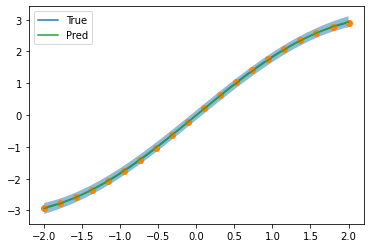

In [85]:
model.eval()
likelihood.eval()

test_x = torch.linspace(-2, 2, 200)
test_y = torch.sin(test_x)+test_x
plt.plot(test_x, test_y, label="True")
plt.plot(train_x,train_y,'o')
observed_pred = likelihood(model(test_x))
lower,upper = observed_pred.confidence_region()


plt.plot(test_x, observed_pred.mean[0].detach().numpy(), label="Pred")
plt.fill_between(test_x.detach().numpy(), lower[0, :].detach().numpy(), upper[0, :].detach().numpy(), alpha=0.5)

# plt.scatter(x, y, label="Obs")
plt.legend()

In [7]:
x=0
y = np.array([1,1])
np.sum(y)+x

2